<a href="https://colab.research.google.com/github/RK22000/Rahuls-Another-Motion-Picture-Review-Classifier/blob/main/MPRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get the DataPoints

In [ ]:
pos_path = r"/content/drive/MyDrive/CS_156/assignment_2b1/Movie Reviews/pos"
neg_path = r"/content/drive/MyDrive/CS_156/assignment_2b1/Movie Reviews/neg"

In [ ]:
import os
def get_files(folder:str) -> list:
    """
    Get the files in the folder
    """
    files = []
    if folder:
        for filename in os.listdir(folder):
            f = os.path.join(folder, filename)
            if os.path.isfile(f):
                files.append(f)
    return files

In [ ]:
pos_dps = [ [file, 1, None, None] for file in get_files(pos_path) ] 
neg_dps = [ [file, 0, None, None] for file in get_files(neg_path) ]

# Determine how to split the DataPoints in to sets
80% training, 10% validation, 10% testing

In [ ]:
#import random
#random.seed("Rahul's Lucky Random Seed")
def list_splitter(full_set, valid_frac, test_frac):
    full_size = len(full_set)
    v_idx = int(valid_frac*full_size)
    t_idx = v_idx+int(test_frac*full_size)
    valid_dps = full_set[0:v_idx]
    test_dps = full_set[v_idx:t_idx]
    train_dps = full_set[t_idx:]
    return train_dps, valid_dps, test_dps

def get_data_sets(pos_dps, neg_dps, valid_frac, test_frac):
    train_pos_dps, valid_pos_dps, test_pos_dps = list_splitter(full_set=pos_dps, valid_frac=valid_frac, test_frac=test_frac)
    train_neg_dps, valid_neg_dps, test_neg_dps = list_splitter(full_set=neg_dps, valid_frac=valid_frac, test_frac=test_frac)

    train_set = train_pos_dps+train_neg_dps
    valid_set = valid_pos_dps+valid_neg_dps
    test_set  = test_pos_dps+test_neg_dps

    return train_set, valid_set, test_set



In [ ]:
train_set, valid_set, test_set = get_data_sets(pos_dps, neg_dps, 0.1, 0)

# Get the data value and pre process it

In [ ]:
import re
regex = re.compile('a')
a_s = ["abc", "has", "bat", "cool"]

for i, word in enumerate(a_s):
    a_s[i] = regex.sub("A", word)

a_s

['Abc', 'hAs', 'bAt', 'cool']

In [ ]:
import re

def get_review(f_path):
    with open(f_path, "r") as f:
        rev = f.read()
    return rev

# Parameter is string
# Return value is a preprocessed strings (to lowered, removed special characters, etc)
def review_preprocess(review: str):
    # lowercase everything
    review = review.lower()

    
    review = review.split("\n")
    bad = re.compile(
        '''[.,\\(\\)\\{\\}\\[\\]"'-:;\\?]|&nbsp|&quot|&#137'''
    )
    for i, line in enumerate(review):
        review[i] = bad.sub("", line)


    #bad_chars = set(['.','(',')','{','}','[',']','"',"'",'-',':',';','?', ','])
    #bad_words = set(['&nbsp', '&quot', '&#137']) # Just some bad words I noticed in the data
    #bad = set.union(bad_chars, bad_words)
    #for i, line in enumerate(review):
    #    review[i] = " ".join([ word for word in line.split() if word not in bad ])

    return review

def review_tokenizer(preproc_review: str, n=20):
    """Tokenize the preprocessed review
    :param preproc_review: the preprocessed review
    :returns: a list of tokens in the preprocessed review. words in the review and pairs of consecutive words in the review count as tokens"""
    tokens = []
    
    for line in preproc_review:
        words = line.split()
        for token_size in range(1, 1+min(n, len(words))):
            groups = [ words[offset:len(words)-token_size+1+offset] for offset in range(token_size) ]
            for token in zip(*groups):
                tokens.append(" ".join(token))
    return tokens

def data_preprocess(data: str):
    return review_tokenizer(review_preprocess(data))

In [ ]:
# ~ 1min run time
print("Loading reviews")
for dp in train_set:
    dp[2] = get_review(dp[0])

print("Pre-processing reviews")
for dp in train_set:
    dp[3] = data_preprocess(dp[2])

Loading reviews
Pre-processing reviews


In [ ]:
len(train_set[0]) # 0: id, 1: label, 2: raw review, 3: processed review

4

# Train a model on the pre processed data

## Steps to train a model starting with training data

1. Identify the usefull tokens - give it to model
    1. Count occurance of each token in pos and neg case
    1. Use count to calculate the information in each token
    1. Pick all tokens that are usefull enough

1. Identify the post probabalities of usefull tokens - give it to model
    1. Calculate the post prob for each token in the token set

1. Test the model on the data


In [ ]:
import math
import heapq

class BayesianClassifier:
    def __init__(self, token_probs: dict, preprocesser) -> None:
        self.token_probs = token_probs
        self.preprocesser = preprocesser  # Each key will eventually
                                                            # map to prob for class 1 or 0
    
    def get_top_evidence(self, n=5):
        top_pos = heapq.nlargest( n=n, iterable=self.token_probs, key=lambda token:self.token_probs[token][0] )
        top_neg = heapq.nlargest( n=n, iterable=self.token_probs, key=lambda token:self.token_probs[token][1] )
        return ({evidence: self.token_probs[evidence] for evidence in top_pos},
                {evidence: self.token_probs[evidence] for evidence in top_neg}) 
    
    def is_pos_review(self, review, threshold=None):
        """Method to ask model to predict wheter the movie review is positive or negative"""
        if threshold is None:
            threshold = self.__threshold
        return self.prob_pos_review(review)>threshold
    
    @property
    def threshold(self):
        return self.threshold

    def set_threshold(self, threshold):
        self.__threshold = threshold
    
    def prob_pos_review(self, review):
        review = self.preprocesser(review)
        score = 1
        cond_probabilities = self.token_probs
        for token in review:
            if token in self.token_probs:
                post_pos, post_neg = cond_probabilities[token]
                score *= (post_pos/post_neg)
        
        return math.log2(score) if score != 0 else -200 # Try log(score)  cus the score gets allo over the place

class BCTrainer:
    def __init__(self, train_set: list, preprocesser, threshold=0.3) -> None:
        self.train_set = train_set
        # Prep the token set
        token_counter , case_counter = self.tally_tokens(train_set=train_set)
        self.token_counter = token_counter
        self.all_tokens = token_counter.keys()
        self.token_utility = { token: self.token_information(token_counter[token]) for token in token_counter.keys() }
        self.max_token_utility = max(self.token_utility.values())
        self.set_token_set(threshold=threshold)

        # Calculate conditional probabalities
        self.case_counter = case_counter
        token_probs = {token: self.token_probabalities(token_counter[token], case_counter) for token in self.token_set}

        # Create Model
        self.model = BayesianClassifier(token_probs=token_probs, preprocesser=preprocesser)


    @staticmethod
    def token_probabalities(token_count, case_count, delta=0.01):
        prob_post_neg = (token_count[0] + delta)/ (case_count[0] )
        prob_post_pos = (token_count[1] + delta)/ (case_count[1])
        return prob_post_pos, prob_post_neg

    def set_token_set(self, threshold=0.3):
        token_utility = self.token_utility
        max_token_utility = self.max_token_utility
        token_set = [token for token in self.all_tokens if token_utility[token] > threshold*max_token_utility]
        self.token_set = sorted(token_set, key=lambda token: token_utility[token], reverse=True)




    @staticmethod
    def tally_tokens(train_set: list):
        token_counter = dict()
        class_counter = [0, 0]
        for dp in train_set:
            class_counter[dp[1]] += 1
            for token in set(dp[3]): # dp 3 maps to pre processed data
                token_counter.setdefault(token, [0,0])[ dp[1] ] += 1 # dp 1 maps to the classification of dp
        return token_counter, class_counter
    
    @staticmethod
    def token_information(token_count: list):
        
        pos_token_freq = token_count[1]
        neg_token_freq = token_count[0]
        total_count = pos_token_freq+neg_token_freq

        pos_prob = pos_token_freq/total_count
        neg_prob = neg_token_freq/total_count

        pos_entropy = pos_prob*math.log2(pos_prob) if not pos_prob == 0 else 0
        neg_entropy = neg_prob*math.log2(neg_prob) if not neg_prob == 0 else 0
        
        return (1 + pos_entropy + neg_entropy) * math.log2(total_count)

In [ ]:
trainer = BCTrainer(train_set=train_set, preprocesser=data_preprocess)

In [ ]:
n = 10
print(f"top {5}")
for i in range(n):
    token = trainer.token_set[i]
    print(f'\t{token}, {trainer.token_utility[token]}')

print(f"bottom {n}")

for i in reversed(range(1, n+1)):
    token = trainer.token_set[-i]
    print(f'\t{token}, {trainer.token_utility[token]}')

top 5
	this turkey, 4.247927513443585
	witty and, 4.169925001442312
	this mess, 4.169925001442312
	perfect for, 4.087462841250339
	outstanding, 4.015729156556218
	gripping, 4.0
	ludicrous, 3.996888378436427
	of the worst, 3.9536330012136935
	well worth, 3.9068905956085187
	worst movie, 3.807354922057604
bottom 10
	the fun, 1.28489428418578
	shine, 1.28489428418578
	continues to, 1.28489428418578
	gem, 1.28489428418578
	family is, 1.28489428418578
	different from, 1.2837082972067106
	german, 1.2837082972067106
	faced, 1.2837082972067106
	doesnt even, 1.2837082972067102
	breasts, 1.2837082972067102


In [ ]:
trainer.model.get_top_evidence(n=5)

({'brilliant': (0.1172962962962963, 0.039518518518518515),
  'memorable': (0.09877777777777778, 0.029641975308641978),
  'of the best': (0.129641975308642, 0.030876543209876546),
  'one of the best': (0.09877777777777778, 0.018530864197530864),
  'subtle': (0.09137037037037038, 0.025938271604938272)},
 {'boring': (0.053098765432098766, 0.16791358024691358),
  'should have': (0.04198765432098765, 0.13211111111111112),
  'stupid': (0.03458024691358025, 0.15062962962962964),
  'the worst': (0.039518518518518515, 0.13581481481481483),
  'worst': (0.046925925925925926, 0.18890123456790123)})

In [50]:
import matplotlib.pyplot as plt
import statistics

class Tester:
    def __init__(self, model, valid_set):
        self.model = model
        self.valid_set = valid_set
        
    def test(self, threshold=1.0, verbose=False):
        def verbate(msg):
            if verbose:
                print(msg)
        
        verbate(f"Testing threshold: {threshold}")
        true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
        is_pos = self.model.is_pos_review
        l_tests = len(self.valid_set)
        
        for i, dp in enumerate(self.valid_set):
            verbate(f'\ttesting case {i}/{l_tests}')
            actual = True if dp[1]==1 else False
            predic = is_pos(dp[2], threshold)

            if actual and predic: true_pos += 1
            elif not (actual or predic): true_neg += 1
            elif actual and (not predic): false_pos += 1
            else: false_neg += 1

        total_tests = true_pos + true_neg + false_pos + false_neg
        accuracy = (true_pos+true_neg)/total_tests
        tnr = true_neg/(true_neg+false_neg)
        tpr = true_pos/(true_pos+false_pos)
        return accuracy, tpr, tnr
    
    def plot_thresholds(self, thresholds, xscale='linear', verbose=False, make_plot=True):
        results = [ self.test(threshold=thresh, verbose=verbose) for thresh in thresholds ]
        accus, tprs, tnrs = zip(*results)
        if make_plot:
            plt.plot(thresholds, accus, "ro-", label="accuracy")
            plt.plot(thresholds, tprs, "go-", label="true positive rate")
            plt.plot(thresholds, tnrs, "bo-", label="true negative rate")
            plt.legend()

        best = max(enumerate(results), key=lambda z:z[1][0])[0]
        best = thresholds[best]
        plt.plot([best, best], [0, 1], "-")
        plt.text(best, 0, str(best))

        return best

        #plt.xscale(xscale)
        #plt.plot(thresholds, t)
    
    def plot_scores(self, threshold=None, verbose=False, make_plots=True):
        prob_pos = self.model.prob_pos_review
        x_pos, x_neg = 0.75, 0.25

        y_pos = []
        y_neg = []

        for dp in self.valid_set:
            y = y_pos if dp[1]==1 else y_neg
            y.append(prob_pos(dp[2]))

        if make_plots:
            plt.plot([x_pos]*len(y_pos), y_pos, "g.", label="positive reviews")
            plt.plot([x_neg]*len(y_neg), y_neg, "r.", label="negative reviews")
            if threshold is not None:
                plt.plot([0,1], [threshold]*2, "-", label="Threshold")
                plt.text(0.5, threshold, str(threshold), weight='black', ha='center')
        
        critical_scores = sorted([max(y_pos), min(y_pos), max(y_neg), min(y_neg)])[1:3]

        if make_plots:
            plt.plot([0,1], [critical_scores[0]]*2, "--", )
            plt.text(0.5, critical_scores[0], str(critical_scores[0]), weight='black', ha='center')
            plt.plot([0,1], [critical_scores[1]]*2, "--", )
            plt.text(0.5, critical_scores[1], str(critical_scores[1]), weight='black', ha='center')
            plt.legend()

        return critical_scores
        #plt.title("Scores in log scale")
        #plt.yticks([])
        #plt.xticks([0.25, 0.75], ['Negative reviews', 'Positive reviews'])
        #plt.ylabel("log scale")
        #plt.yscale('log')

    def get_best_threshold(self, make_plots=True, title="Binary Classifier plots"):
        if make_plots:
            plt.figure(figsize=(15, 7))
            plt.suptitle(t=title)

            plt.subplot(1,2,1)
            plt.title("Score Distribution")
        ll, ul = self.plot_scores(make_plots=make_plots)

        if make_plots:
            plt.subplot(1, 2, 2)
            plt.title("Thresholds")
        return self.plot_thresholds(np.linspace(start=ll, stop=ul, num=10,), make_plot=make_plots)
    
        

    

In [ ]:
for dp in valid_set:
    dp[2] = get_review(dp[0])

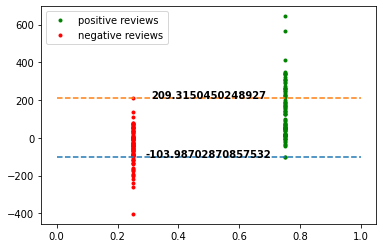

In [ ]:
tester = Tester(trainer.model, valid_set)
ll, ul = tester.plot_scores()

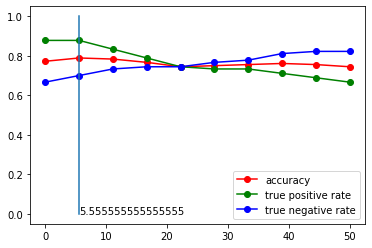

In [ ]:
import numpy as np
#tester = Tester(model, data_sets.valid_set)
#ll, ul = 0, 50
bestish = tester.plot_thresholds(np.linspace(start=ll, stop=ul, num=10), verbose=False)

In [ ]:
tester.test(threshold=bestish)

(0.7888888888888889, 0.8777777777777778, 0.7)

0.44699586924734547

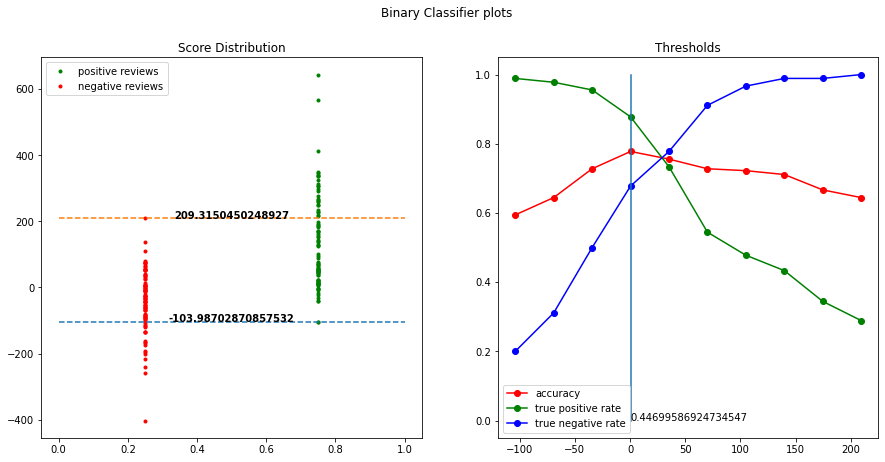

In [51]:
tester = Tester(model=trainer.model, valid_set=valid_set)
tester.get_best_threshold()

#Ensemble attempt

In [52]:
import random
random.seed("Rahul's Lucky Seed")
def split_set(train_set: list, n=5):
    shuffeled_set = train_set + []
    random.shuffle(shuffeled_set)
    window = int(len(shuffeled_set)/n)
    train_sets = []
    for i in range(n-1):
        train_sets.append( shuffeled_set[i*window: (i+1)*window] )
    train_sets.append( shuffeled_set[(n-1)*window: ] )
    return train_sets

In [ ]:
len(train_set)

1440

In [53]:
train_sets = split_set(train_set=train_set, n=5)

In [ ]:
len(train_sets[4])

288

In [54]:
import numpy as np

class EnsembleClassifier:
    def __init__(self, *weighted_models) -> None:
        self.weighted_models = weighted_models
        #self.total_weight = sum(map(lambda model: model.weight))

    def is_pos_review(self, review, *kargs):
        vote = [0,0]
        for model in self.weighted_models:
            vote[model.is_pos_review(review)] += 1
        return vote[0] < vote[1]

    
class ECTrainer:
    def __init__(self, train_set: list, valid_set: list, preprocesser, n=5) -> None:
        self.train_sets = split_set(train_set=train_set, n=n)
        self.trainers = [ BCTrainer(train_set=ts, preprocesser=preprocesser) for ts in self.train_sets ]
        self.models = [ trainer.model for trainer in self.trainers ]
        for i, model in enumerate(self.models):
            tester = Tester(model=model, valid_set=valid_set)
            #ll, ul = tester.plot_scores()
            #bestish = tester.plot_thresholds(np.linspace(start=ll, stop=ul, num=10), verbose=False)
            bestish = tester.get_best_threshold(make_plots=True, title=f'Model {i}')
            model.set_threshold(bestish)
            accuracy = tester.test(bestish)[0]
            model.weight = accuracy
            print(f'Model {i}: {accuracy}')
        self.model = EnsembleClassifier(*self.models)

        
        

Model 0: 0.7777777777777778


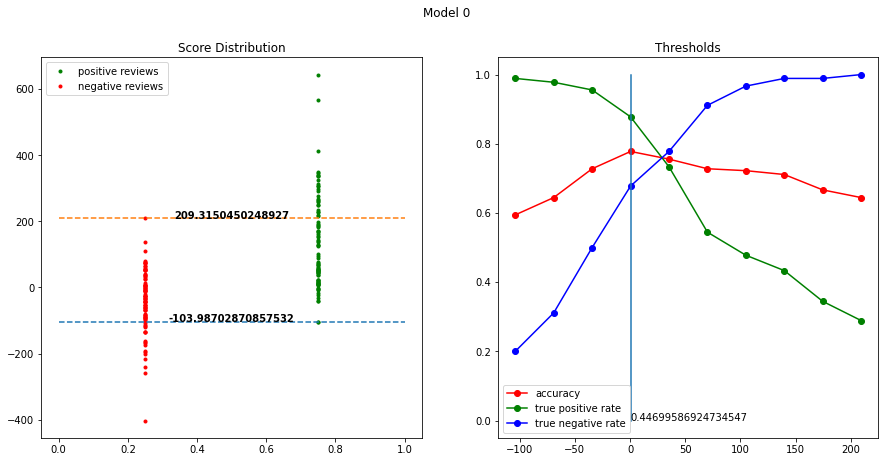

In [55]:
ec_trainer = ECTrainer(train_set=train_set, valid_set=valid_set, preprocesser=data_preprocess, n=1)

In [56]:
ec_tester = Tester(ec_trainer.model, valid_set)
ec_tester.test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # This is added back by InteractiveShellApp.init_path()


(0.7777777777777778, 0.8777777777777778, 0.6777777777777778)

Model 0: 0.7222222222222222
Model 1: 0.7
Model 2: 0.7666666666666667


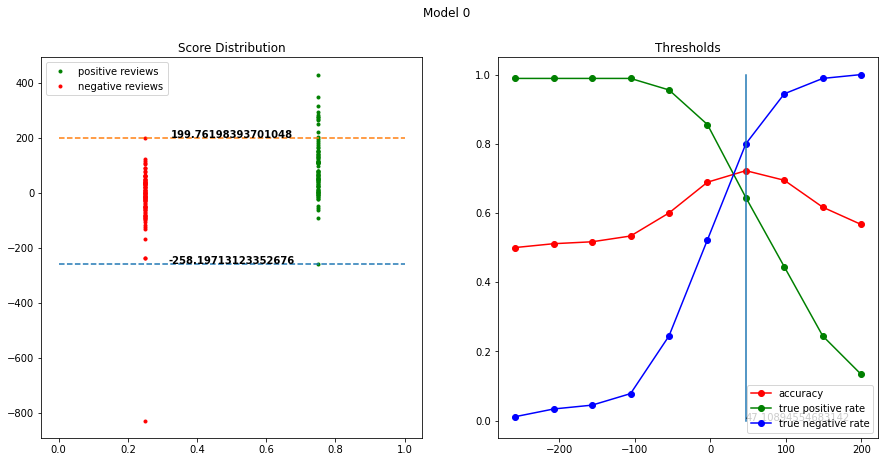

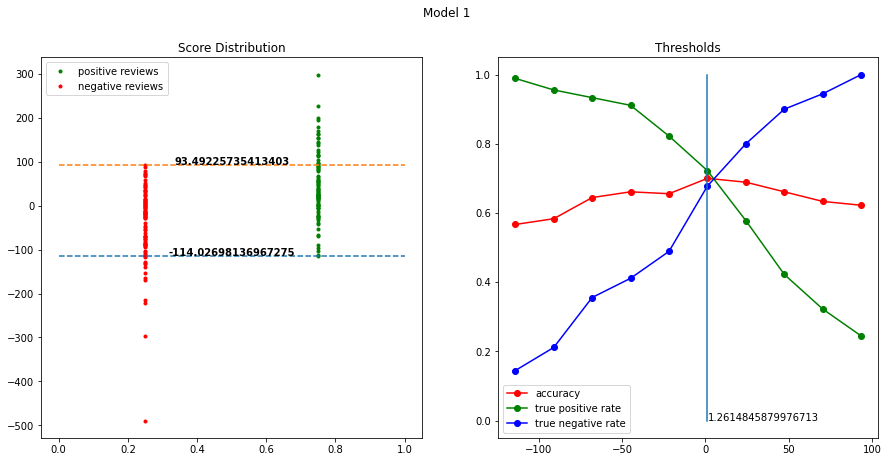

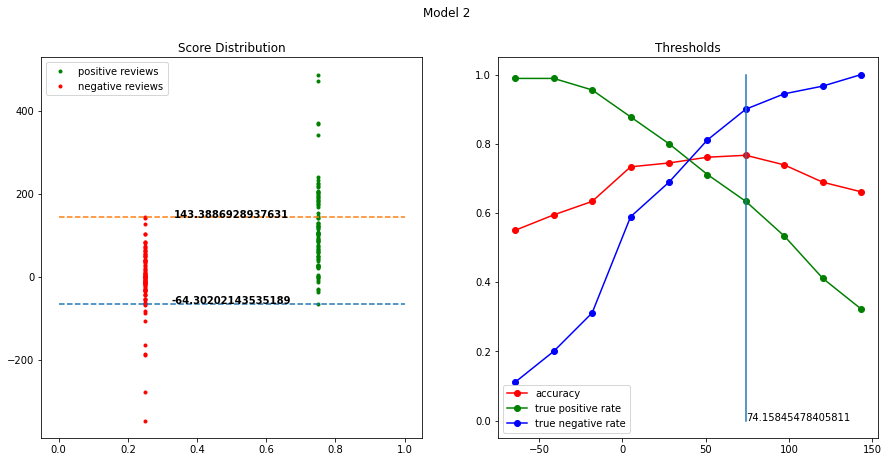

In [57]:
ec_trainer = ECTrainer(train_set=train_set, valid_set=valid_set, preprocesser=data_preprocess, n=3)

In [58]:
ec_tester = Tester(ec_trainer.model, valid_set)
ec_tester.test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # This is added back by InteractiveShellApp.init_path()


(0.7611111111111111, 0.6777777777777778, 0.8444444444444444)

Model 0: 0.6722222222222223
Model 1: 0.7
Model 2: 0.6833333333333333
Model 3: 0.7055555555555556
Model 4: 0.6944444444444444


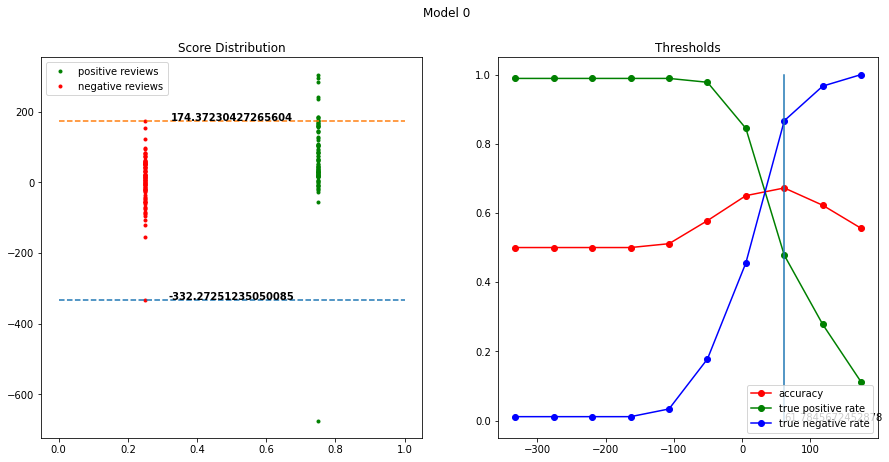

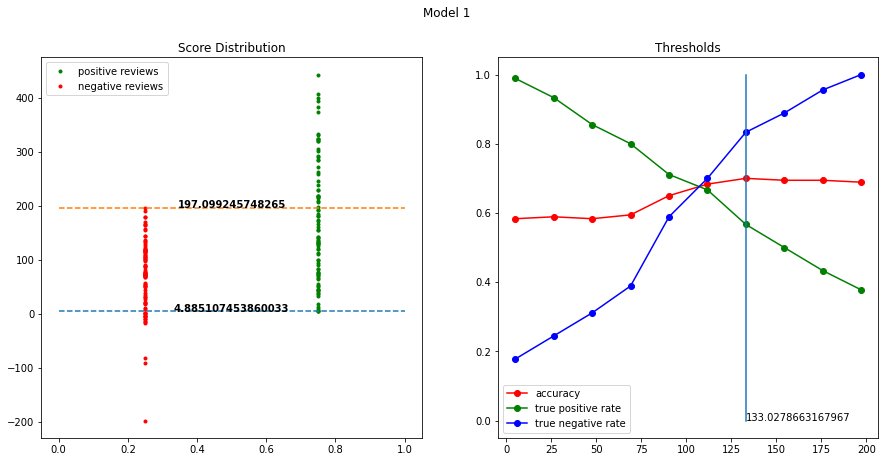

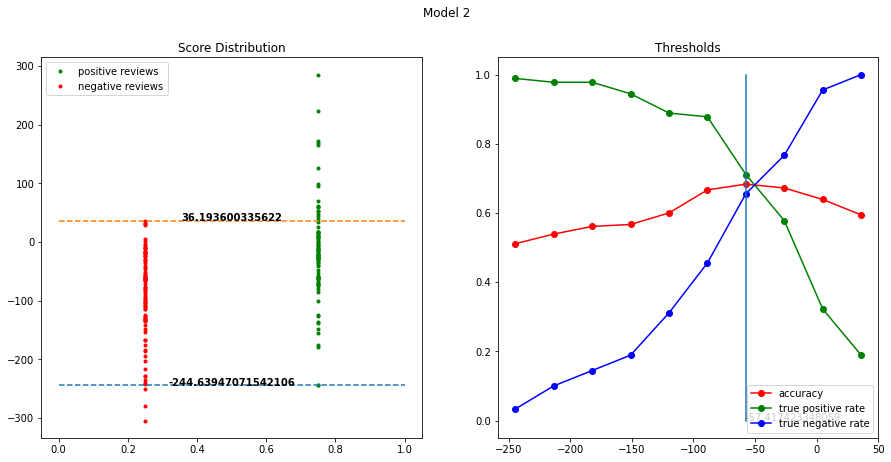

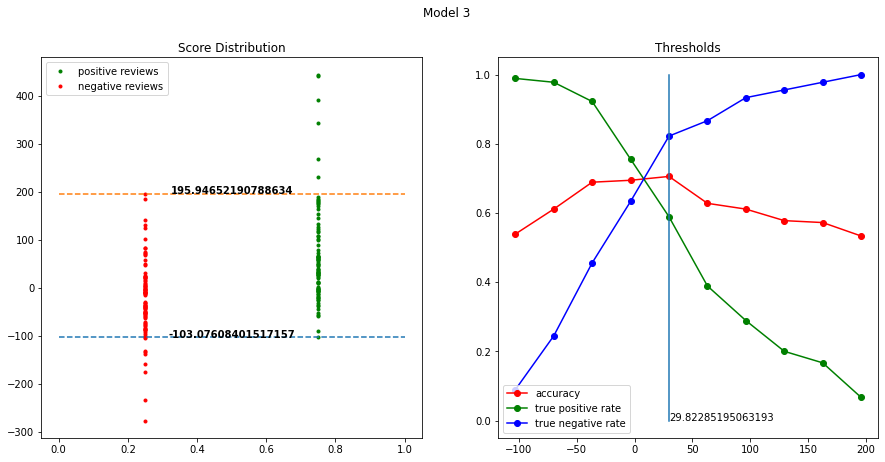

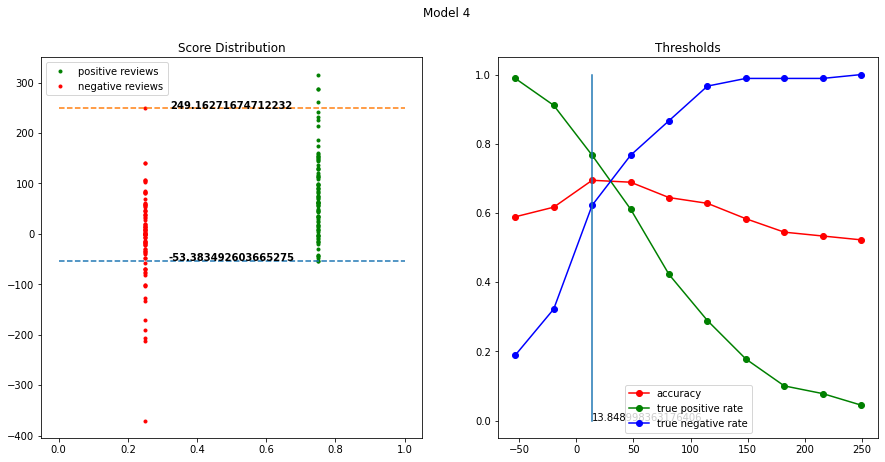

In [59]:
ec_trainer = ECTrainer(train_set=train_set, valid_set=valid_set, preprocesser=data_preprocess, n=5)

In [60]:
ec_tester = Tester(ec_trainer.model, valid_set)
ec_tester.test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # This is added back by InteractiveShellApp.init_path()


(0.75, 0.6222222222222222, 0.8777777777777778)